# Homework Solution: Creating Long Cluster States

We will simulate the algorithm described in [PRL 95, 080503 (2005)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.080503) which describes an algorithm to create arbitrary long cluster states for any success rate $p$ of the CZ gate.

The algorithm has two steps. (1) We first find a method to create a bunch of Cluster states of length $n_0$. (2) We try to add all of these cluster states by applying CZ gates.

For simplicity, let us assume that $n_0$ in step (1) is a power of two. We adopt a recursive protocol. To create a cluster state of length $n_0$, we first create two cluster states of length $n_0/2$. We then try connect them by applying a CZ gate. If we succeed, we are done. If the CZ gate fails, we discard the cluster states and start over again.

The number of CZ gates $M$ that one needs to apply to create a cluster state of length $n_0$ can be shown to scale as

$$
M(n_0) = \frac{1}{2}\left(\frac{2}{p}\right)^{\log_2 n_0}
$$

which is polynomial in $n_0$ and therefore still efficient.

We implement this recursive algorithm below.

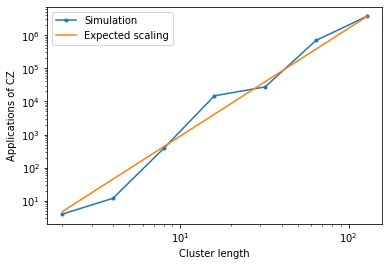

In [3]:
import numpy as np
import matplotlib.pyplot as plt

p = 0.21 # success probability
M = 0 # number of attempts (number of applied CZ gates)

def buildClusterState(n):
    global M
    if n == 1:
        # no CZ gates are required for cluster state of length 1,
        # so success probability is 1
        return True

    # build two cluster states of length n/2
    # this makes the function recursive
    buildClusterState(n/2)
    buildClusterState(n/2)

    # now try to connect them
    M += 1 # number of attempts M increases by 1

    if np.random.rand() < p:
        # CZ gate was successful, we are done!
        return True
    else:
        # CZ gate failed, start over again
        buildClusterState(n)

LL = []
MM = []

for i in np.arange(1,8):
    M = 0
    buildClusterState(2**i)
    LL.append(2**i)
    MM.append(M)

plt.loglog(LL, MM,'.-', label='Simulation');
plt.loglog(LL, (2/p)**(np.log(LL)/np.log(2))/2, label='Expected scaling');
plt.xlabel('Cluster length');
plt.ylabel('Applications of CZ');
plt.legend();

Once we have two cluster states of length $n_0$, we try to connect them by applying a CZ gate. If we succeed, the total length increases by $n_0$. If the CZ gate fails, we can still recover two cluster states of length $(n_0-2)$ which we try to connect again.

The average length of the combined cluster state is

$$
\sum_{i=0}^{n_0/2} 2(n_0-2i)p(1-p)^i \approx 2n_0 - 4(1-p)/p
$$

which is greater than $n_0$ for $4(1-p)/p < n_0$.

Thus, if the length of the initial two chains is larger than

$$
n_c = 4(1-p)/p
$$

the chain will grow on average.

We implement this idea in the code below.

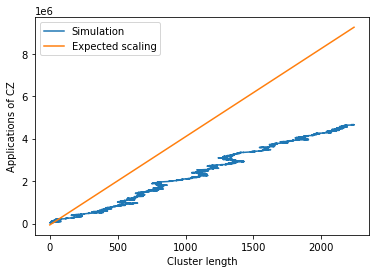

In [6]:
# find the next highest power of 2 that is greater than n_c

# compute n_c, the minimum required length of the initial cluster chains prepared by the code above
n_c = 4 * (1-p)/p 

#find the closest power of 2 that is greater than n_x
n_0 = pow(2, np.ceil(np.log(n_c)/np.log(2)))
if n_0 == n_c:
    n_0 *= 2

# M stores the number of applied CZ gates (the number of attempts)    
M = 0

#build two initial chains of length n_0
buildClusterState(n_0)
L = n_0 # L keeps track of the length of the first chain

buildClusterState(n_0)
L2 = n_0 # L2 keeps track of the length of the second chain

LL = []
MM = []

for i in np.arange(5000):
    # attempt to connect the two cluster chains
    r = np.random.rand()
    M += 1 # increase number of attempts by 1

    if r < p:
        # connection was successful
        L += L2
        # create a new cluster chain of lenth n_0
        buildClusterState(n_0)
        L2 = n_0
    else:
        # connection failed. Remove the broken parts and try connecting them again in next loop
        L -= 2
        L2 -= 2

    if L < 1:
        L = 1
    if L2 < 1:
        L2 = 1

    # keep track of the total length for each loop iteration
    LL.append(L)
    MM.append(M)


plt.figure()
plt.plot(LL,MM, label='Simulation')
x = np.arange(np.max(LL))
plt.plot(x,(2/p)**(np.log(n_c+1)/np.log(2)) * (x - n_c)/2, label='Expected scaling')
plt.xlabel('Cluster length');
plt.ylabel('Applications of CZ');
plt.legend();

We see that the cluster length is scales polynomially with the number of CZ attempts. Thus, we can efficiently generate long cluster states, even for very faulty CZ gates!

## A final word

But what is the point of all this? 

If we had access to perfect single qubit rotations, but a very error-prone CZ gate, quantum computation on a gate-based quantum computer would be impossible. However, for the measurement based way, we have shown that it is possible to efficiently create arbitrary long cluster states even for arbitrarily high error rate of the CZ gate. Once we have the cluster state, we only need to perform single qubit measurements and don't need any entangling gates anymore. Thus, measurement based quantum computation still works!